In [1]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 8 # Amount of documents
V = 12 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 10 


k = 5 # Amount of topics
gamma = 0.2  #

In [2]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 100 # Amount of documents
V = 18 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 5 

k = 6 # Amount of topics
gamma = 0.2

# FA: Since we're testing so much, lets agree on using just 1 small set of global variables for now

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

From now on let's use the following simulated data for further testing

In [4]:
from simulator import Simulator
from samplers import MC_sample_Z, MC_sample_B, MC_sample_H, MC_sample_GK
from transformation_functions import update_Theta, update_Sigma, update_E, update_C
from generator_functions import sample_Z_from_W

# 3. MAIN CYCLE TESTS

### Generating Target Data

These data will be used as input (matrix Z and W) and target (matrix G) for our simulation. 

In [5]:
simulated_data = Simulator(D, V, M, k, gamma, seed=1888)
simulated_data.generate_all_data()

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


In [6]:
# Input Data:
simulated_data.W

array([[1., 3., 0., ..., 0., 5., 4.],
       [2., 2., 0., ..., 0., 2., 2.],
       [2., 5., 1., ..., 1., 3., 4.],
       ...,
       [1., 5., 0., ..., 0., 1., 1.],
       [1., 2., 0., ..., 0., 0., 3.],
       [5., 5., 0., ..., 1., 5., 3.]])

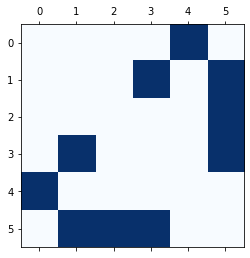

In [7]:
# Target graph
plt.matshow(simulated_data.G, cmap='Blues')

### Generating Initial Data

These are used as our initial guess for Sigma, K, B, Theta and G

In [8]:
# # Initial guesses
initial = Simulator(D, V, M, k, gamma, 2020)
initial.sample_GK()
initial.sample_B()
initial.sample_H()

Success: Sigma transformed from K
Success: G transformed from K


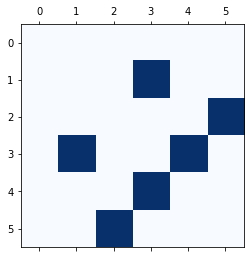

In [9]:
# Initial graph
plt.matshow(initial.G, cmap='Blues')

## 3.1 Test without Z sampler
Z, E and C are never updated. We use the true versions instead

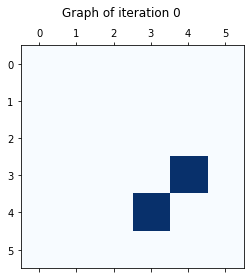

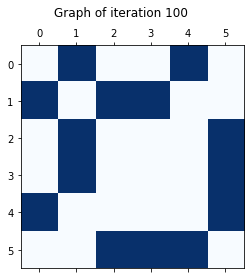

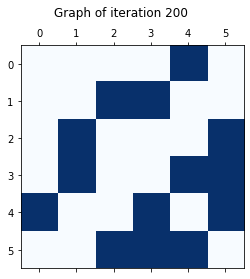

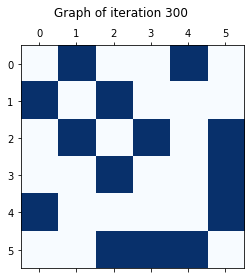

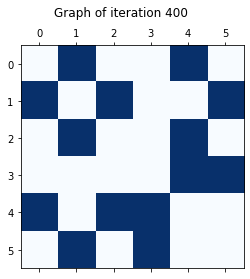

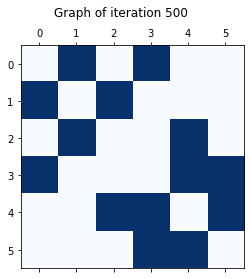

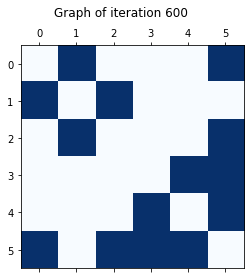

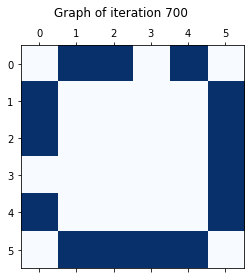

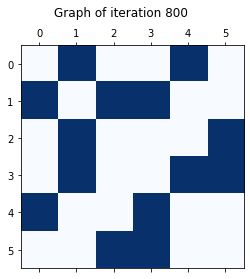

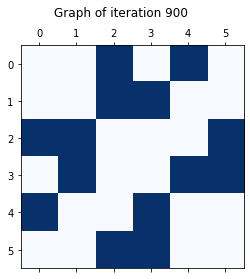

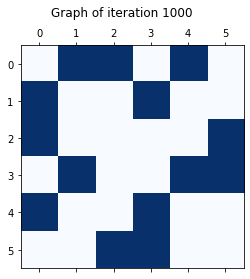

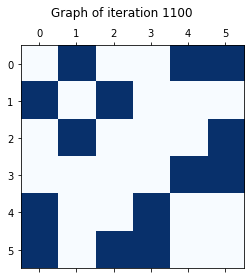

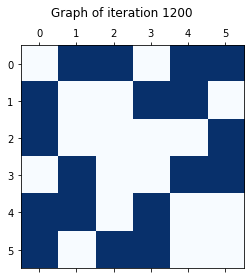

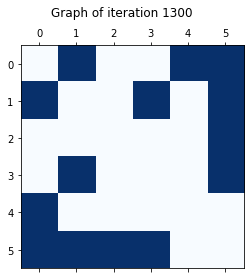

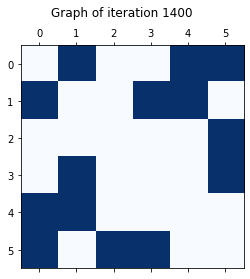

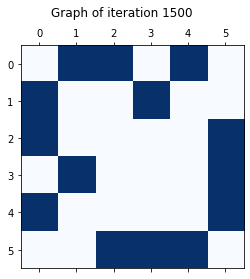

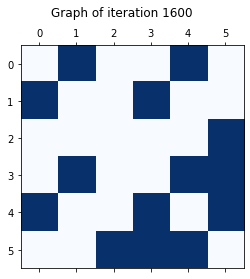

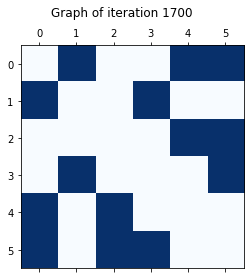

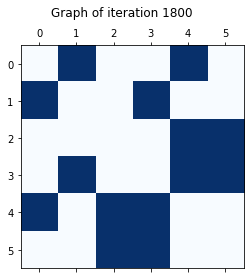

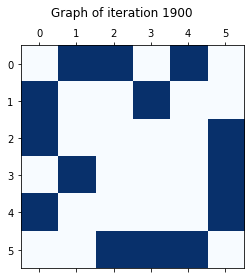

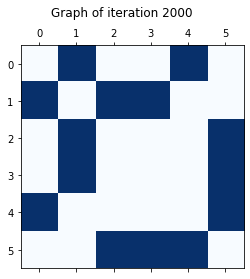

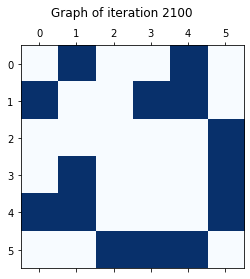

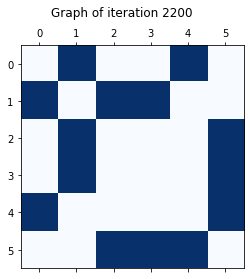

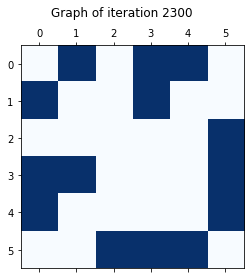

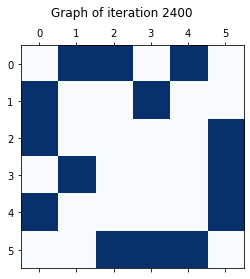

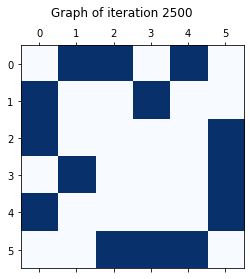

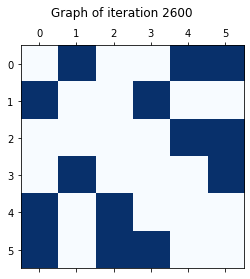

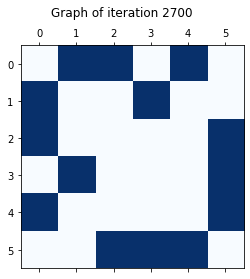

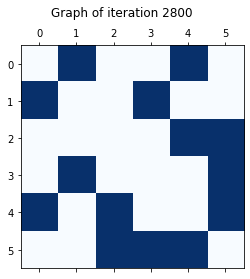

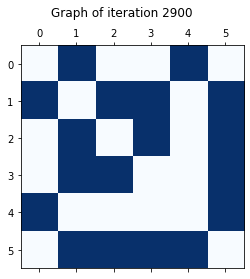

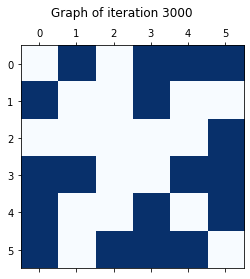

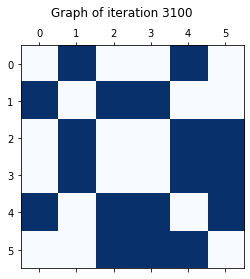

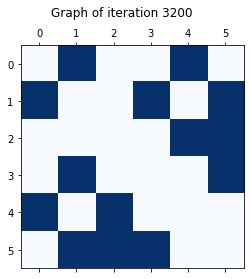

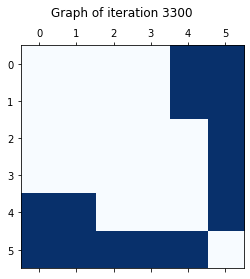

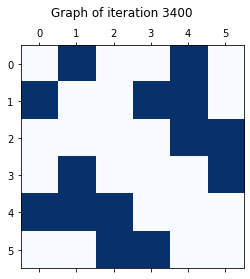

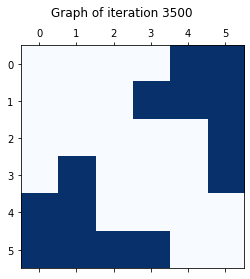

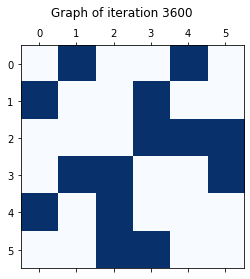

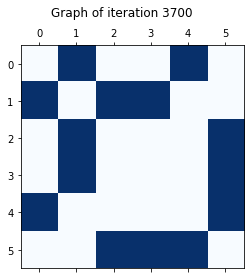

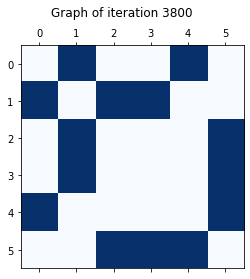

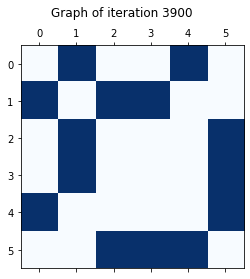

CPU times: user 10min 24s, sys: 21.2 s, total: 10min 45s
Wall time: 1h 31min 43s


In [10]:
%%time
max_iterations = 4000
np.random.seed(25041945)

# Initialization
Sigma = initial.Sigma.copy()
K = np.linalg.inv(Sigma)
B = initial.B.copy()
Theta = initial.Theta.copy()
G = initial.G.copy()

alpha = np.ones(V)  # Uninformative prior
b = k - 1

# Skipping part
Z = simulated_data.Z.copy()
E = simulated_data.E.copy()
C = simulated_data.C.copy()

H = None

waiting_times = []
sampled_Gs = []
edges_log = []
errors_log = []
graph_changes = []

for iteration in range(max_iterations):
    
    # Step 1
    #Z, E, C = MC_sample_Z(Z, simulated_data.W, Theta, B, E, C, debug=True) 
    
    # Step 2
    B = MC_sample_B(alpha, C)
    
    # Step 3
    H = MC_sample_H(E, Sigma, H_current=H, burn_in=10)
    Theta = update_Theta(Theta, H)  # get Theta from H
    
    # Step 4    
    G_old = G.copy()
    wt_sample, G_new, K = MC_sample_GK(G, H, b, debug=False)
    #if np.all(G_new == G_old):
    #    print('G matrix has NOT changed!')
    graph_changes.append(~np.all(G_new == G_old))
    G = G_new
    Sigma = np.linalg.inv(K)
    
    waiting_times.append(wt_sample)
    sampled_Gs.append(G.copy())
    
    # Hope for convergence!
    wrong_edges = np.sum(G != simulated_data.G)
    error = np.linalg.norm(Sigma - simulated_data.Sigma)
    #print(f"At iteration {iteration}, the wrong edges are {wrong_edges} and the error on Sigma is {error}. Waiting time {wt_sample}")
    
    edges_log.append(wrong_edges)
    errors_log.append(error)
    
    if iteration % 100 == 0:  # Plot every 20 iterations
        plt.matshow(G, cmap='Blues')
        plt.suptitle("Graph of iteration " + str(iteration), x=0.5, y=1, ha='center')
        plt.show()

Wrong edges metrics
count    4000.00000
mean        8.72500
std         2.38491
min         4.00000
25%         8.00000
50%         8.00000
75%         8.00000
max        24.00000
dtype: float64


Text(0.5, 1, 'G wrong edges histogram')

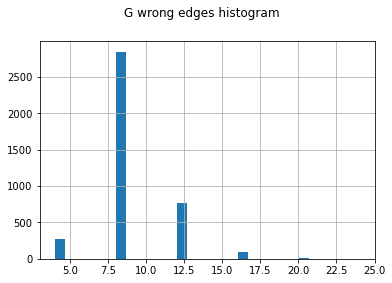

In [11]:
wrong_edges = pd.Series(edges_log)

print("Wrong edges metrics")
print(wrong_edges.describe())

wrong_edges.hist(bins=30)
plt.suptitle('G wrong edges histogram', x=0.5, y=1, ha='center')

<AxesSubplot:title={'center':'Wrong edges series'}>

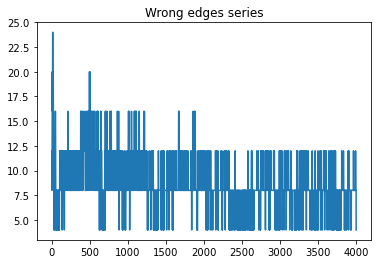

In [12]:
wrong_edges.plot(title="Wrong edges series")

Sigma errors metrics
count    4000.000000
mean      301.966710
std        80.151667
min         9.542886
25%       243.367820
50%       306.847175
75%       356.753931
max       610.505960
dtype: float64


Text(0.5, 1, 'Sigma L2-errors histogram')

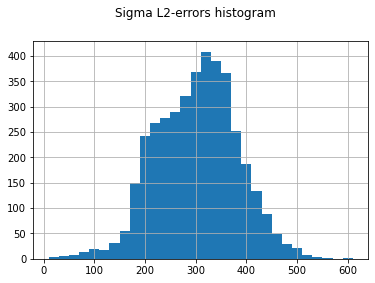

In [13]:
Sigma_errors = pd.Series(errors_log)

print("Sigma errors metrics")
print(Sigma_errors.describe())

Sigma_errors.hist(bins=30)
plt.suptitle('Sigma L2-errors histogram', x=0.5, y=1, ha='center')

<AxesSubplot:title={'center':'Sigma L2-errors series'}>

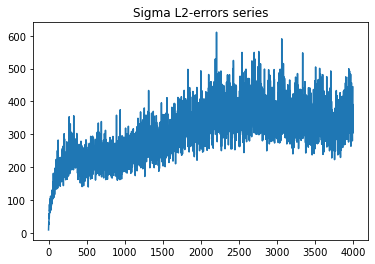

In [14]:
Sigma_errors.plot(title="Sigma L2-errors series")

<AxesSubplot:title={'center':'Waiting times series'}>

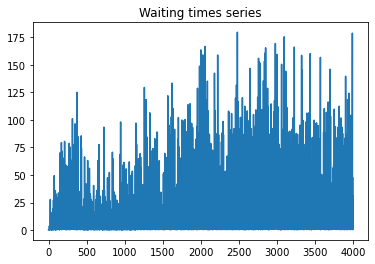

In [15]:
wait_times = pd.Series(waiting_times)
wait_times.plot(title="Waiting times series")

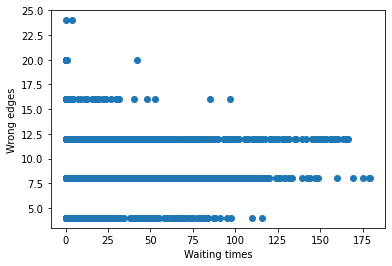

In [16]:
plt.scatter(wait_times, wrong_edges)
plt.xlabel('Waiting times')
plt.ylabel('Wrong edges')
plt.show()

G matrix changes (1 = changed, 0 = same)
count    4000.000000
mean        0.707750
std         0.454853
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64


Text(0.5, 1, 'Graph changes histogram (1 = changed, 0 = same)')

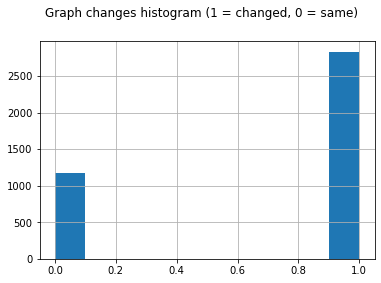

In [17]:
matrix_changes = pd.Series(graph_changes).astype(int)

print("G matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())

matrix_changes.hist()
plt.suptitle("Graph changes histogram (1 = changed, 0 = same)", x=0.5, y=1, ha='center')

<AxesSubplot:title={'center':'G changes series'}>

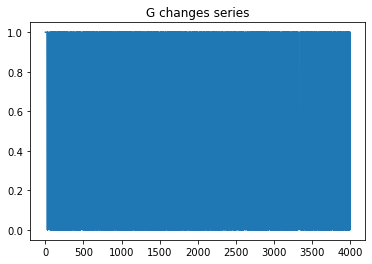

In [18]:
matrix_changes.plot(title='G changes series')